In [1]:
import xgboost as xgb
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper import extract_data, create_features, sorted_correlations_with_gold, remove_correlated_features

In [2]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

In [3]:
# load model
model = pickle.load(open("model/gold_price.pickle.dat", "rb"))

# load features
features_list = []

with open('model/features.txt', 'r') as f:
    for line in f:
        features_list.append(line[:-1])

In [4]:
n_days_ahead = 3

latest_date = date.today()
end_date = latest_date.strftime("%Y-%m-%d")
start_date = (latest_date - timedelta(days=200)).strftime("%Y-%m-%d")
print("start_date: %s" %start_date)
print("end_date: %s" %end_date)
print("forecasting price of gold for %s" %(latest_date+ timedelta(days=n_days_ahead)).strftime("%Y-%m-%d"))

start_date: 2020-01-03
end_date: 2020-07-21
forecasting price of gold for 2020-07-24


In [5]:
infer_values = extract_data(start_date,(latest_date+timedelta(days=1)).strftime("%Y-%m-%d"), tickers)
infer_values.tail()

,date,Gold,Silver,Crude Oil,S&P500,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100
196,2020-07-17,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.61,25.68,42.77,1.14,1006.22
197,2020-07-18,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.61,25.68,42.77,1.14,1006.22
198,2020-07-19,1810.5,19.75,40.64,3224.73,139.34,110.41,852.5,2.91,96.61,25.68,42.77,1.14,1006.22
199,2020-07-20,1819.6,20.36,40.65,3251.84,139.44,110.42,862.6,2.93,96.61,24.46,43.32,1.14,1012.81
200,2020-07-21,1828.6,20.95,42.16,3265.06,139.38,110.41,879.8,2.94,95.39,24.51,43.86,1.15,1016.82


In [6]:
features_list

['Gold_t-1',
 'Gold_t-7',
 'Gold_t-14',
 'Silver_t-2',
 '10 Yr US T-Note futures_t-21',
 '10 Yr US T-Note futures_t-30',
 'Euronext100_t-1',
 'Platinum_t-2',
 'Volatility Index_t-30',
 'Gold_rocr_3',
 '10 Yr US T-Note futures_rocr_3']

In [7]:
infer_features = create_features(infer_values)
infer_features = infer_features[['date']+features_list]
infer_features.tail()

,date,Gold_t-1,Gold_t-7,Gold_t-14,Silver_t-2,10 Yr US T-Note futures_t-21,10 Yr US T-Note futures_t-30,Euronext100_t-1,Platinum_t-2,Volatility Index_t-30,Gold_rocr_3,10 Yr US T-Note futures_rocr_3
16,2020-07-17,0.007954,0.004601,0.018091,-0.005539,0.003240,0.006645,-0.002360,0.006621,-0.232746,-18.025135,-0.817008
17,2020-07-18,0.000000,0.004601,0.018091,0.011783,0.003240,0.005556,0.000000,0.020741,-0.220401,-0.000000,0.000000
18,2020-07-19,-0.000883,0.003547,0.013264,0.000000,0.000790,0.003674,0.000000,0.001292,-0.268793,-0.124990,0.181936
19,2020-07-20,0.005026,0.009823,0.016536,0.030886,0.001580,0.004394,0.006549,0.013155,-0.303531,1.214406,1.250179
20,2020-07-21,0.004946,0.008660,0.019571,0.060759,0.000359,0.003962,0.003959,0.032023,-0.302107,0.543206,-2.998279


In [8]:
output = model.predict(infer_features.iloc[:,1:])
df_predict = pd.DataFrame()
df_predict['date'] = infer_features['date']
df_predict['return_prediction'] = output


In [9]:
results = pd.DataFrame()
results['date']  = pd.date_range(start=infer_features['date'].iloc[0], end= infer_features['date'].iloc[-1] + timedelta(days=n_days_ahead))
results = pd.merge(left=results, right=infer_values[['date','Gold']], on='date', how='left')
results = pd.merge(left=results, right=df_predict[['date','return_prediction']], on='date', how='left')
results ['predicted_price'] = results['Gold']*(results ['return_prediction']+1)
results ['predicted_price'] = results ['predicted_price'].shift(n_days_ahead)
results.tail(10)

,date,Gold,return_prediction,predicted_price
14,2020-07-15,1815.0,0.000693,1804.433997
15,2020-07-16,1797.8,0.000553,1802.940722
16,2020-07-17,1812.1,0.000383,1813.235626
17,2020-07-18,1812.1,0.000185,1816.257080
18,2020-07-19,1810.5,0.002171,1798.795062
19,2020-07-20,1819.6,0.001407,1812.793854
20,2020-07-21,1828.6,0.003569,1812.435478
21,2020-07-22,NaN,NaN,1814.430667
22,2020-07-23,NaN,NaN,1822.160227
23,2020-07-24,NaN,NaN,1835.126068


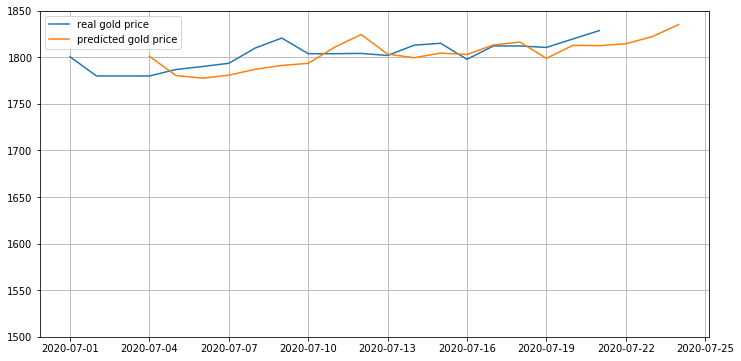

In [10]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Gold'], label="real gold price")
plt.plot(results['date'], results['predicted_price'], label="predicted gold price")
plt.grid()
plt.ylim([1500,1850])
plt.legend()

In [11]:
prediction_date = '2020-07-24'

In [12]:
print("Predicted price for date %s: %2.2f" %(prediction_date,results[results['date']==prediction_date]['predicted_price'].values[0]))

Predicted price for date 2020-07-24: 1835.13
